# Testing How Best To Determine Point Removal

In [1]:
import os
import tsplib95
import pandas as pd
import numpy as np
import statsmodels.api as sm
import signal
import tqdm
from multiprocess import Pool


from wsp import tsp, ds

FILE_DIR = "DATA_GEN_50u"
AX = np.array([None, None])
S_FACTOR = 2.0
TREE_TYPE = ds.PKPRQuadTree

In [2]:
top_problems = sorted(os.listdir(FILE_DIR))

len(top_problems)

676

## Problem Injestion

In [5]:
reduction_df = pd.DataFrame(columns=['name', 'parent', 'path_reduction', 'wsp_reduction'])
reduction_df = reduction_df.astype({'name': str, 'parent': str, 'path_reduction': float, 'wsp_reduction': float})
reduction_df.set_index('name', inplace=True)

In [10]:
removed_problems : list[tsplib95.models.StandardProblem] = []
def setup(top_problem):
    main_problem = tsplib95.load(f"{FILE_DIR}/{top_problem}/{top_problem}.tsp")
    main_conc_cost = float(main_problem.comment.split(' ')[2])
    main_points = [ds.Point(*main_problem.node_coords[i]) for i in main_problem.get_nodes()]
    main_problem_object = tsp.TravellingSalesmanProblem[TREE_TYPE](TREE_TYPE, main_points, AX, s=S_FACTOR)
    main_cost = main_problem_object.calc_dist(
        [main_points[i-1] for i in main_problem.tours[0]] + [main_points[main_problem.tours[0][0] - 1]]
    )
    
    updates = []
    for removal_name in os.listdir(f"{FILE_DIR}/{top_problem}"):
        if '_' not in removal_name: continue

        sub_problem = tsplib95.load(f"{FILE_DIR}/{top_problem}/{removal_name}")
        sub_conc_cost = float(sub_problem.comment.split(' ')[2])
        sub_points = [ds.Point(*sub_problem.node_coords[i]) for i in sub_problem.get_nodes()]
        sub_problem_object = tsp.TravellingSalesmanProblem[TREE_TYPE](TREE_TYPE, sub_points, AX, s=S_FACTOR)
        sub_cost = sub_problem_object.calc_dist(
            [sub_points[i-1] for i in sub_problem.tours[0]] + [sub_points[sub_problem.tours[0][0] - 1]]
        )
        
        # reduction_df.loc[f"{sub_problem.name}"] = {
        #     'parent': top_problem,
        #     'path_reduction': sub_cost / main_cost, 
        #     'wsp_reduction': len(sub_problem_object.wspd) / len(main_problem_object.wspd)
        # }
        
        updates.append({f"{sub_problem.name}" : {
            'parent': top_problem,
            'path_reduction': sub_cost / main_cost, 
            'wsp_reduction': len(sub_problem_object.wspd) / len(main_problem_object.wspd)
        }})
    return updates

original_sigint_handler = signal.signal(signal.SIGINT, signal.SIG_IGN)
pool = Pool(6) # NUMBER OF PROCESSES
signal.signal(signal.SIGINT, original_sigint_handler)

update_collection = []
u=0
try:
    with tqdm.tqdm(total=len(top_problems), unit="top problem") as pbar:
        for result in pool.imap_unordered(setup, top_problems):
            update_collection.append(result)
            pbar.update(1)
            prob_name = next(iter(result))
            u += 1
            # if result[prob_name] != {}:
            #     u += 1
            #     # pbar.set_postfix(pf := {**pf, **{"last": prob_name, "last_updated": prob_name, "updated": u}})
            # else:
            #     # pbar.set_postfix(pf := {**pf, **{"last": prob_name}})
except KeyboardInterrupt:
    print("Caught KeyboardInterrupt, terminating workers")
    pool.terminate()
else:
    pool.close()
pool.join()

print("Injesting updates")
for updates in update_collection:
    for update in updates:
        for key, value in update.items():
            reduction_df.loc[key, value.keys()] = value.values()
  
reduction_df.shape
reduction_df

100%|██████████| 676/676 [00:26<00:00, 25.89top problem/s]


Injesting updates


,parent,path_reduction,wsp_reduction
name,,,
aa50u_46,aa50u,0.999178,0.993651
aa50u_47,aa50u,0.999926,0.993651
aa50u_45,aa50u,0.997591,0.977778
aa50u_50,aa50u,0.994147,0.996825
aa50u_44,aa50u,0.987424,0.952381
...,...,...,...
zz50u_47,zz50u,0.982597,0.961310
zz50u_46,zz50u,0.982189,0.925595
zz50u_50,zz50u,0.995592,0.973214


## Global Checks and Figures

In [11]:
results = sm.OLS(reduction_df["path_reduction"], sm.add_constant(reduction_df["wsp_reduction"])).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     2520.
Date:                Tue, 28 Jan 2025   Prob (F-statistic):               0.00
Time:                        17:27:17   Log-Likelihood:             1.0918e+05
No. Observations:               33800   AIC:                        -2.184e+05
Df Residuals:                   33798   BIC:                        -2.183e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.8951      0.002    467.594      0.000       0.891       0.899
wsp_reduction     0.0988      0.002     50.199      0.000       0.095       0.103
==============================================================================
Omnibus:                    15559.825   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           100139.924
Skew:                          -2.135   Prob(JB):                         0.00
Kurtosis:                      10.272   Cond. No.                         73.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: xlabel='wsp_reduction', ylabel='path_reduction'>

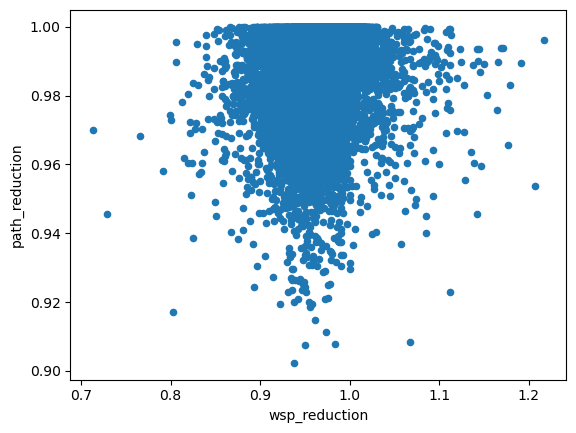

In [12]:
reduction_df.plot.scatter("wsp_reduction", "path_reduction")

In [13]:
path_smallest = reduction_df.groupby("parent").apply(lambda df: df.nsmallest(1, 'path_reduction'))
path_largest = reduction_df.groupby("parent").apply(lambda df: df.nlargest(1, 'path_reduction'))

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_75108/1782352281.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  path_smallest = reduction_df.groupby("parent").apply(lambda df: df.nsmallest(1, 'path_reduction'))
/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_75108/1782352281.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  path_largest = reduction_df.groupby("parent").apply(lam

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.510
Date:                Tue, 28 Jan 2025   Prob (F-statistic):              0.220
Time:                        17:27:25   Log-Likelihood:                 1975.4
No. Observations:                 676   AIC:                            -3947.
Df Residuals:                     674   BIC:                            -3938.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.9407      0.012     79.674      0.000       0.917       0.964
wsp_reduction     0.0151      0.012      1.229      0.220      -0.009       0.039
==============================================================================
Omnibus:                       99.753   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              148.076
Skew:                          -1.004   Prob(JB):                     7.01e-33
Kurtosis:                       4.108   Cond. No.                         47.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

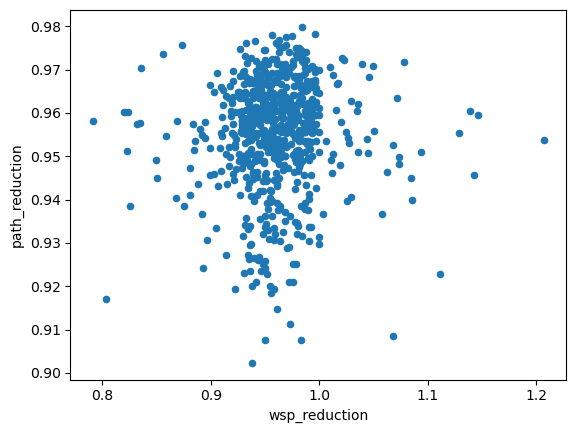

In [14]:
path_smallest.plot.scatter("wsp_reduction", "path_reduction")
results = sm.OLS(path_smallest["path_reduction"].astype(float), sm.add_constant(path_smallest["wsp_reduction"].astype(float))).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.510
Date:                Tue, 28 Jan 2025   Prob (F-statistic):              0.220
Time:                        17:27:27   Log-Likelihood:                 1975.4
No. Observations:                 676   AIC:                            -3947.
Df Residuals:                     674   BIC:                            -3938.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.9407      0.012     79.674      0.000       0.917       0.964
wsp_reduction     0.0151      0.012      1.229      0.220      -0.009       0.039
==============================================================================
Omnibus:                       99.753   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              148.076
Skew:                          -1.004   Prob(JB):                     7.01e-33
Kurtosis:                       4.108   Cond. No.                         47.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

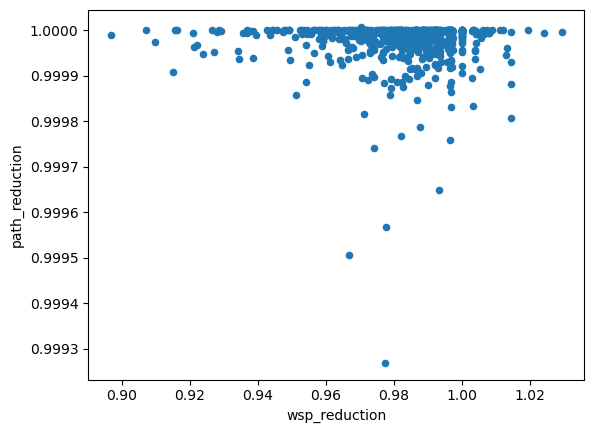

In [15]:
path_largest.plot.scatter("wsp_reduction", "path_reduction")
results = sm.OLS(path_smallest["path_reduction"].astype(float), sm.add_constant(path_smallest["wsp_reduction"].astype(float))).fit()
results.summary()